# Predictive Maintenance

BACKGROUND A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive maintenance solution to proactively identify when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted. GOAL you are tasked with building a predictive model-using machine learning to predict the probability of a device failure. When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure. 
DATA Download link: http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv


## Load Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from tqdm import tqdm

## Process and analyze data

In [2]:
raw_data = pd.read_csv('predictive_maintenance.csv')

In [3]:
raw_data.shape

(124494, 12)

In [4]:
raw_data.dtypes

date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

In [5]:
raw_data.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/15,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,1/1/15,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/15,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/15,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/15,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
#Look at any other nulls
count_nan = len(raw_data) - raw_data.count()
print(count_nan[count_nan > 0])

Series([], dtype: int64)


In [7]:
#Let's look at number of unique values per column
raw_data.apply(pd.Series.nunique)

date          304
device       1169
failure         2
metric1    123877
metric2       558
metric3        47
metric4       115
metric5        60
metric6     44838
metric7        28
metric8        28
metric9        65
dtype: int64

Metrics with a low number of unique values could indicate that the variable may not be continuous. Another important note is that there are only 1169 devices. This could mean that the same device could be fixed, and then appear again as a new entry.

In [8]:
raw_data.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


Looking at these statistics, we can see that the fields are on very different scales. Additionally, we can see that metrics 7 and 8 may be the same. The other important observation is that there are almost no failure entries.

In [9]:
#Let's look at the failure spread
print('This is the failure to no failure split' )
print(raw_data['failure'].value_counts())

This is the failure to no failure split
0    124388
1       106
Name: failure, dtype: int64


In [10]:
# Is metric 7 exactly the same as 8?

print(sum(raw_data['metric7'] != raw_data['metric8']))

0


Removing metric 8 since it's the same as 7.

In [11]:
#Since all entries are the same, we can remove one of them

df = raw_data.drop('metric8', axis = 1)

In [12]:
all_cols = df.columns.tolist()

### Are any metrics categorical?

In [13]:
print(' Out of {} records with no nulls, we have the following:'.format(len(df)))

top_n = 10 # top categories by volume we are interested in looking at 
thresh = .9 #Threshold percentage of column entries used captured by the top_n categories 
cat_var = [] #Stores categorical candidates
for var in df.columns:
    if df[var].value_counts(normalize=True).head(top_n).sum() > thresh and var != 'failure':
        
        top10_amt = round(df[var].value_counts(normalize=True).head(top_n).sum(),3)
        
        print('\n Variable {} has {} unique values and its top 10 categories ' \
        'encapture {} of data'.format(var, len(df[var].unique()), top10_amt))
        
        zero_percent = round(df[df[var] == 0].shape[0]/df.shape[0],3)
        
        print(' {} Variable is populated by {} percent zeros'.format(var, zero_percent))

        one_to_thresh =  round(df[var].value_counts(normalize=True).head(top_n)[1:top_n].sum(),3)
        
        print(' Excluding the top category, the top 10 (2-10) encapture {} percent '\
              'of the data'.format(one_to_thresh))


       
        cat_var.append(var)
    

 Out of 124494 records with no nulls, we have the following:

 Variable metric2 has 558 unique values and its top 10 categories encapture 0.963 of data
 metric2 Variable is populated by 0.949 percent zeros
 Excluding the top category, the top 10 (2-10) encapture 0.014 percent of the data

 Variable metric3 has 47 unique values and its top 10 categories encapture 0.974 of data
 metric3 Variable is populated by 0.927 percent zeros
 Excluding the top category, the top 10 (2-10) encapture 0.048 percent of the data

 Variable metric4 has 115 unique values and its top 10 categories encapture 0.984 of data
 metric4 Variable is populated by 0.925 percent zeros
 Excluding the top category, the top 10 (2-10) encapture 0.059 percent of the data

 Variable metric7 has 28 unique values and its top 10 categories encapture 1.0 of data
 metric7 Variable is populated by 0.988 percent zeros
 Excluding the top category, the top 10 (2-10) encapture 0.011 percent of the data

 Variable metric9 has 65 uniqu

Given the observations above, as a first pass, metrics 2, 3, 4, 7 and 9 will be turned into binaries; 0 or not 0. 

In [14]:
for binary in cat_var:
    
    df[binary] = np.where(df[binary] == 0, 0, 1)

In [15]:
#Check one

df['metric2'].value_counts(normalize= True).head(10)

0    0.94872
1    0.05128
Name: metric2, dtype: float64

Now scale data given the observed differences across metrics.

In [16]:
#metric col names
metric_cols = df.columns.tolist()

metric_cols.remove('device')
metric_cols.remove('date')
metric_cols.remove('failure')

In [17]:
print(metric_cols) 

['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric9']


In [18]:
#Now scale metric columns using min max scaler
scaler = MinMaxScaler()

df[metric_cols] = scaler.fit_transform(df[metric_cols]) #Min Max scaling binary columns will result in the same values

Visualizing metrics below.

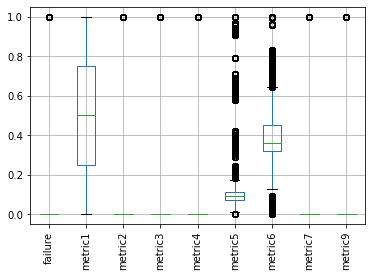

In [19]:
df.boxplot(rot = 90)

In [20]:
metrics_df = df[metric_cols]

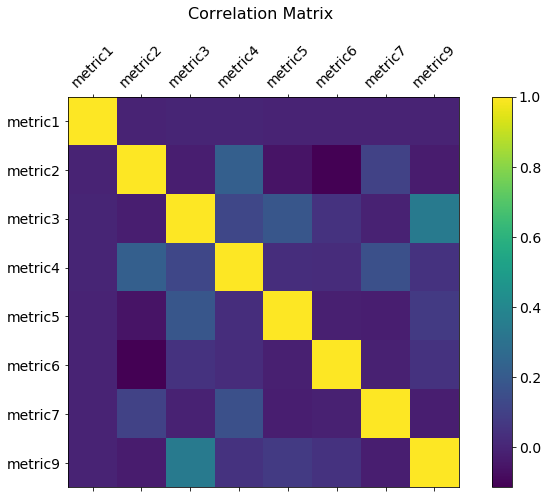

In [21]:
f = plt.figure(figsize=(12, 7))
plt.matshow(metrics_df.corr(), fignum=f.number)
plt.xticks(range(metrics_df.shape[1]), metrics_df.columns, fontsize=14, rotation=45)
plt.yticks(range(metrics_df.shape[1]), metrics_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix \n \n \n', fontsize=16);

## Time Series Analysis

In [22]:
#Look at timeframe
df['date'] =  pd.to_datetime(df['date']).dt.date

print('earliest date: {}'.format(df['date'].min()))
print('latest date: {}'.format(df['date'].max())) 

earliest date: 2015-01-01
latest date: 2015-11-02


Below is a visualization of the number of entries and failures over time.

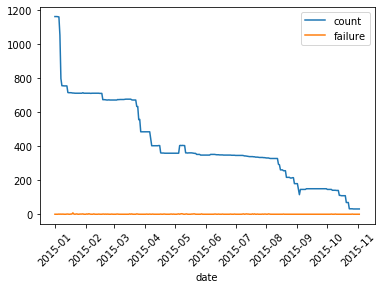

In [23]:
to_plot = df.groupby('date').agg({'device':'count', 'failure': 'sum'}).reset_index().set_index('date')

to_plot.rename(columns={'device':'count'}).plot(rot = 45)

The few failures recorded present a challenge in visualizing when presented with the entry counts. For this reason, a visualization of failures alone is included below.

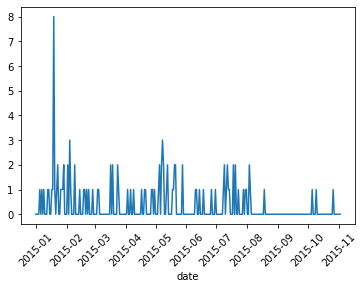

In [24]:
df.groupby('date')['failure'].sum().plot(rot = 45)

### When were devices introduced into the logs?

In [25]:
print(df.groupby('device')['date'].min().value_counts())

2015-01-01    1163
2015-05-06       4
2015-01-27       1
2015-06-13       1
Name: date, dtype: int64


### How many entries do we have per device?

In [26]:
#Printing the top of the list 
print(df['device'].value_counts().reset_index().sort_values('device', ascending = False).head(5))

       index  device
0   Z1F0QLC1     304
14  W1F0FY92     304
1   S1F0GGPP     304
26  W1F0JXDL     304
25  Z1F0KJDS     304


In [27]:
#Printing the bottom of the list 

print(df['device'].value_counts().reset_index().sort_values('device', ascending = True).head(5))

         index  device
1168  W1F1DA5ÿ       1
1167  W1F0WJFT       3
1166  S1F04KSC       4
1165  S1F0A1VP       5
1088  W1F1CAKS       5


In [28]:
#Picking an arbitrary device to see how their status progressed over time

arbitrary_device_df = df[df['device']== 'Z1F0GB8A'].sort_values('date')

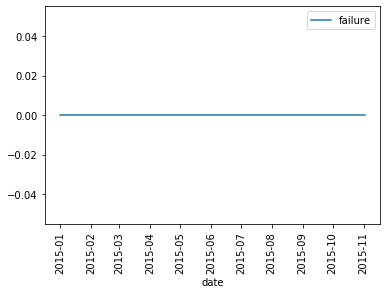

In [29]:
arbitrary_device_df[['date', 'failure']].set_index('date').plot(rot = 90)

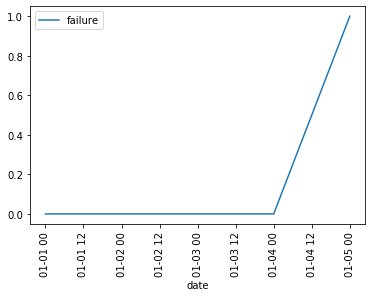

In [30]:
#Let's find an arbitrary device that failed

arbitrary_device = df['device'][df['failure'] == 1].iloc[0]

arbitrary_device_df = df[df['device'] == arbitrary_device]
# arbitrary_device_df
arbitrary_device_df[['date', 'failure']].set_index('date').plot(rot = 90)

### Do devices fail more than once?

In [31]:
#Let's find any devices that failed multiple times

failed_multiple = df.groupby('device').agg({'failure':'sum'}).sort_values('failure', ascending = False)

failed_multiple.head()

,failure
device,
Z1F0LSNZ,1
W1F1230J,1
Z1F0P5D9,1
S1F0L0DW,1
W1F1DQN8,1


No devices failed more than once.

### Do any devices come back after they are fixed?

In [32]:
#Get the last dates for each device
df_date = df.groupby('device').agg({'date':max})

df_date.date.to_dict()


df['max_date']=df.device.map(df_date.date.to_dict())
df['max_date_minus_date'] = df['max_date'] - df['date']

#If a device failed and it's date is not the max date, then this device stayed on afterwards
df_not_removed=df[(df.failure==1)&(df.date!=df.max_date)]

df_not_removed = df_not_removed[['date','device', 'max_date', 'max_date_minus_date']]

#Keep list of devices in case they are needed later
fail_devices_not_removed = df_not_removed['device'].tolist()

df_not_removed


,date,device,max_date,max_date_minus_date
77958,2015-05-05,S1F136J0,2015-05-06,1 days
79590,2015-05-09,W1F0KCP2,2015-05-11,2 days
79601,2015-05-09,W1F0M35B,2015-05-11,2 days
101999,2015-07-12,S1F0GPFZ,2015-07-24,12 days
104223,2015-07-18,W1F11ZG9,2015-08-17,30 days


Removing post-failure entries for these devices as these were still recorded after failure, but the fail status is only reported once.

In [33]:
fail_dates = df.groupby('device').apply(lambda x: x[x['failure'] == 1]).set_index('device')['date']

df['fail_date'] = df['device'].map(fail_dates)

df = df[~(df['date'] > df['fail_date'])]

df.shape

(124447, 14)

In [34]:
#Regenerate max date now that the data has been trimmed

#Get the last dates for each device
df_date = df.groupby('device').agg({'date':max})

df_date.date.to_dict()


df['max_date']=df.device.map(df_date.date.to_dict())

### Did late start cases had enough time to fail based on what we can dicern from normal start cases?

Looking at the typical start cases that failed first, how long did it take before they went offline?

In [35]:
#How long does it typically take for devices to fail?

normal_start = df.groupby('device').filter(lambda g: ((g['date'].min() == df['date'].min()) & \
                                                      (g['failure'].sum() == 1)))

time_alive = normal_start.groupby('device')['date'].apply(lambda x: x.max() -x.min()).reset_index()

time_alive['date'] = time_alive['date'].dt.days.astype('int16')

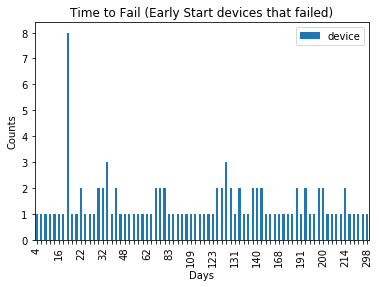

In [36]:
axarr = time_alive.groupby('date').count().plot.bar()
axarr.set_title('Time to Fail (Early Start devices that failed)')
axarr.set_xlabel("Days")
axarr.set_ylabel("Counts")
    
for i, t in enumerate(axarr.get_xticklabels()):
    if (i % 5) != 0:
        t.set_visible(False)

[]

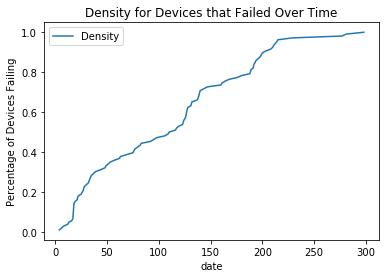

In [37]:
density_alive = time_alive.groupby('date').count().sort_values('date')

density_alive.rename(columns={"device": "Density"}, inplace = True) 

density_alive['Density'] = density_alive['Density'].cumsum()/density_alive['Density'].sum()

ax = density_alive.plot(title = 'Density for Devices that Failed Over Time')

ax.set_ylabel("Percentage of Devices Failing")

ax.plot()

By 200 days, about 80% of these devices had failed.

### Looking at late start cases that did not register a failure - how long were they in the logs?

In [38]:
start_after_min_date = df.groupby('device').filter(lambda g: ((g['date'].min() != df['date'].min()) &\
                                                              (g['failure'].sum() == 0)))

time_alive_late_start = start_after_min_date.groupby('device')['date'].apply(lambda x: x.max()- x.min()).reset_index()
time_alive_late_start['date'] = time_alive_late_start['date'].dt.days.astype('int16')



Text(0, 0.5, 'Counts')

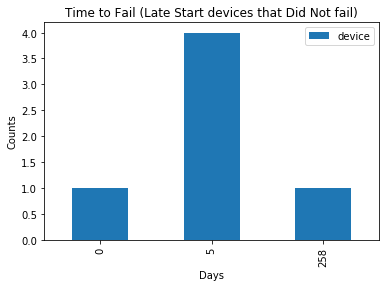

In [39]:
axarr = time_alive_late_start.groupby('date').count().plot.bar()
axarr.set_title('Time to Fail (Late Start devices that Did Not fail)')
axarr.set_xlabel("Days")
axarr.set_ylabel("Counts")
    

The 258 days alive device certainly had enough time to fail, given the density of failed cases. Now consider the 0 and 5 days devices. Why did these disappear from the logs if they didn't fail? Earlier, the dates for the late start devices were captured as 2015-05-06, 2015-01-27, 2015-06-13. It is also clear that the logs report data until November. With this in mind, it may be necessary to remove these five devices that were active for only 0 and 5 days but did not fail.

### How many other deivces never failed but were removed from logs?

In [40]:
removed_no_fail = df.groupby('device').filter(lambda g: ((g['date'].max() != df['date'].max()) & \
                                                      (g['failure'].sum() == 0)))

In [41]:
time_online = removed_no_fail.groupby('device')['date'].apply(lambda x: x.max() -x.min()).reset_index()
time_online['date'] = time_online['date'].dt.days.astype('int16')

There are 1032 devices that were pulled before failing


[]

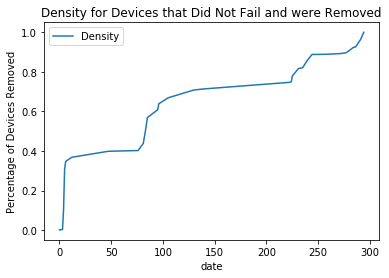

In [42]:
density_removed = time_online.groupby('date').count().sort_values('date')

print('There are {} devices that were pulled before failing'.format(density_removed['device'].sum()))

density_removed.rename(columns={"device": "Density"}, inplace = True) 

density_removed['Density'] = density_removed['Density'].cumsum()/density_removed['Density'].sum()

ax = density_removed.plot(title = 'Density for Devices that Did Not Fail and were Removed')

ax.set_ylabel("Percentage of Devices Removed")

ax.plot()

Interestingly, about 40% of these devices were removed without registered failure in close to 1 day. There is another significant inflection point at about 90 days that accounts for close to 65% of devices cumulatively. Finally, there is a third important inflection point at about 225 days that accounts for 80% of devices cumulatively. 


Earlier we saw that for 80% of devices that failed, we needed about 200 days. One way to tackle the imbalanced dataset would be to remove some of these entries. It may be necessary to come back to this later.

### When were they pulled?

In [43]:
devices_pulled = time_online['device'].unique().tolist()

devices_pulled_plot_df = removed_no_fail.groupby('device')['date'].apply(lambda x : x.max()).reset_index()

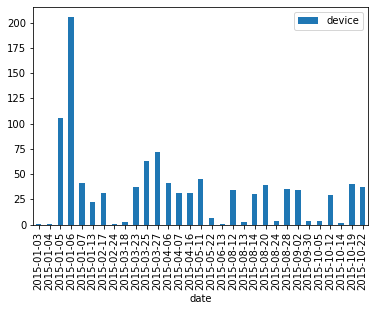

In [44]:
devices_pulled_plot_df[devices_pulled_plot_df['device'].isin(devices_pulled)].\
groupby('date').count().plot.bar(rot = 90)

It appears that 2015-01-05 and 2015-01-06 had a large number of devices pulled, with over 300 in just those two days. This number must correspond to the steep removal of devices (~40%) after only a few days online illustrated in the previous plot.

## Feature Engineering / Data Transformation

It will be helpful to know how many days each device has been online as intuitively speaking, it makes sense for this to be a good signal for predictive models.

In [45]:
df['active_days'] = df.groupby('device')['date'].apply(lambda x: x - x.min())
df['active_days'] = df['active_days'].dt.days.astype('int16')

[]

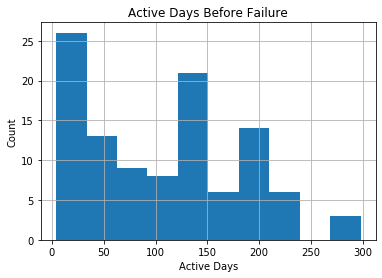

In [46]:
fail_records = df[(~df['fail_date'].isnull()) & (df['date'] == df['max_date'])]

ax = fail_records['active_days'].hist()

ax.set_title("Active Days Before Failure")
ax.set_xlabel("Active Days")
ax.set_ylabel("Count")

ax.plot()

In [47]:
df.shape

(124447, 15)

In [48]:
#Scaling active days as well

df['active_days'] = scaler.fit_transform(np.array(df['active_days']).reshape(-1, 1))

A downward trend is apparent. There may even appear to be two histograms overlaid, each with a separate downward trend.

### Mitigation for Imbalanced Dataset

Given the extremely imbalanced dataset, one possible mitigation is to transform the data to the device level. The data will still be imbalanced, having 1169 unique devices and only 106 that failed, but this should be a lot less problematic.

To avoid losing a lot of information with the transformation, device-level metric statistics will be captured and joined onto the transformed dataset as features. 

In [49]:
#Capture the columns that will be used to generate features with device level statistics
metric_cols = ['metric1', 'metric2', 'metric3', 'metric4','metric5', 'metric6', 'metric7', 'metric9']

In [50]:
#This df will contain all of our original features for the latest records available for each device
max_df = df.groupby('device', group_keys=False).apply(lambda g: g[g['date'] == g['date'].max()])

In [51]:
#Set up min df - will capture the 1st entry for all metrics for each device
min_df = df.groupby('device', as_index = False).apply(lambda g: g[g['date'] == g['date'].min()]).reset_index()

min_df = min_df[['device'] + metric_cols]

min_df.columns = ['device'] + [col+'_min' for col in metric_cols]

In [52]:
# #Set up mean df - will capture the mean for all metrics for each device
mean_df = df.groupby('device', as_index = False).mean().reset_index()

mean_df = mean_df[['device'] + metric_cols]

mean_df.columns = ['device'] + [col+'_mean' for col in metric_cols]

In [53]:
#Set up median df - will capture the median for all metrics for each device

median_df = df.groupby('device', as_index = False).median().reset_index()

median_df = median_df[['device'] + metric_cols]

median_df.columns = ['device'] + [col+'_median' for col in metric_cols]

In [54]:
#Setting up variance - will capture the variance for all metrics for each device

var_df = df.groupby('device', as_index = False).var().reset_index()

var_df = var_df[['device'] + metric_cols]

var_df.columns = ['device'] + [col+'_var' for col in metric_cols]

var_df = var_df.fillna(0) #replacing NaN with 0 for devices with only one log entry



In [55]:
#Setting up last n mean - will capture the mean for all metrics for each device FOR THE LAST N DAYS
l_n =5
last_5 = df.groupby('device', group_keys=False).apply(lambda g: g[g['date'] >= g['date'].max()- \
                                                               timedelta(days=l_n)])

last_5_grouped = last_5.groupby('device', as_index = False).mean().reset_index()

last_5_grouped = last_5_grouped[['device'] + metric_cols]

last_5_grouped.columns = ['device'] + [col+'_last5' for col in metric_cols]


In [56]:
#List of dfs to join
data_frames = [max_df, min_df, mean_df, median_df, var_df, last_5_grouped]

#Left join all dfs
device_level_df = reduce(lambda  left,right: pd.merge(left,right,on=['device'],
                                            how='inner'), data_frames)


In [57]:
#Check new shape
device_level_df.shape

(1169, 55)

In [58]:
#Check for nan/nulls
count_nan = len(device_level_df) - device_level_df.count()
print(count_nan[count_nan > 0])

fail_date    1063
dtype: int64


Only fail date, will remove it next along with other unecessary columns.

In [59]:
cols = [col for col in device_level_df.columns.tolist() if col not in
        ['failure','date', 'device', 'max_date', 'max_date_minus_date', 'fail_date']]

In [60]:
cols

['metric1',
 'metric2',
 'metric3',
 'metric4',
 'metric5',
 'metric6',
 'metric7',
 'metric9',
 'active_days',
 'metric1_min',
 'metric2_min',
 'metric3_min',
 'metric4_min',
 'metric5_min',
 'metric6_min',
 'metric7_min',
 'metric9_min',
 'metric1_mean',
 'metric2_mean',
 'metric3_mean',
 'metric4_mean',
 'metric5_mean',
 'metric6_mean',
 'metric7_mean',
 'metric9_mean',
 'metric1_median',
 'metric2_median',
 'metric3_median',
 'metric4_median',
 'metric5_median',
 'metric6_median',
 'metric7_median',
 'metric9_median',
 'metric1_var',
 'metric2_var',
 'metric3_var',
 'metric4_var',
 'metric5_var',
 'metric6_var',
 'metric7_var',
 'metric9_var',
 'metric1_last5',
 'metric2_last5',
 'metric3_last5',
 'metric4_last5',
 'metric5_last5',
 'metric6_last5',
 'metric7_last5',
 'metric9_last5']

The main problem building a classifier is the imbalanced nature of the dataset. If resampling methods don't work well, some devices that are clearly skewing the data could be removed. These could include devices that did not fail and were removed early in the year only after being active for a few days.

## ML Models

To get started with a baseline, random forrest and svm models will be used with a simple train-test split.

In [61]:
#First split the data into X and y

X = device_level_df[cols]
y = device_level_df['failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 99) # 70% training and 30% test



### Random Forrest

Tree-based models are known to perform well on imbalanced datasets.

In [62]:
rfc = RandomForestClassifier(n_estimators=200)

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

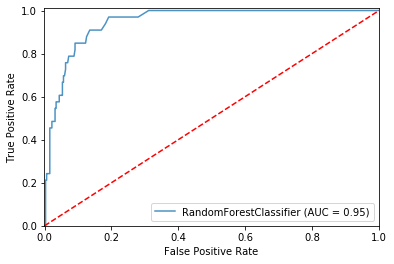

In [63]:
ax = plt.gca()
rfc_disp = metrics.plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.001,1])

plt.ylim([0,1.01])
plt.show()

In [65]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

In [66]:
LR.fit(X_train, y_train)

LogisticRegression()

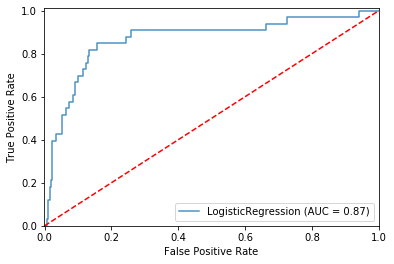

In [70]:
LR.predict(X_test)

ax = plt.gca()
rfc_disp = metrics.plot_roc_curve(LR, X_test, y_test, ax=ax, alpha=0.8)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.001,1])

plt.ylim([0,1.01])
plt.show()




In [79]:
LR_probs = LR.predict_proba(X_test)


p_fail = []
for i in LR_probs:
    p_fail.append(i[1])
    
p_fail = LR_probs[:,1]

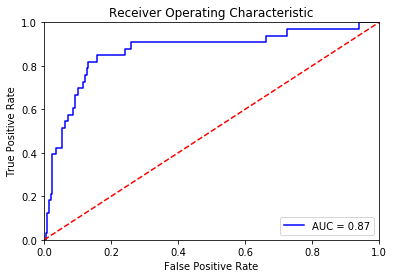

In [80]:
fpr, tpr, threshold = metrics.roc_curve(y_test, p_fail)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [71]:
LR_pred = LR.predict(X_test)

print(metrics.classification_report(y_test,LR_pred))



              precision    recall  f1-score   support

           0       0.93      0.98      0.96       318
           1       0.61      0.33      0.43        33

    accuracy                           0.92       351
   macro avg       0.77      0.66      0.69       351
weighted avg       0.90      0.92      0.91       351



ROC curve and and AUC look incredible, but this is only part of the story; we can't see recall here which will probably be a tough metric given the nature of the dataset.

In [69]:
rfc_pred = rfc.predict(X_test)

print(metrics.classification_report(y_test,rfc_pred))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       318
           1       0.72      0.39      0.51        33

    accuracy                           0.93       351
   macro avg       0.83      0.69      0.74       351
weighted avg       0.92      0.93      0.92       351



The model is great predicting class 0, as expected. Class 1 precision is okay but recall is not good.

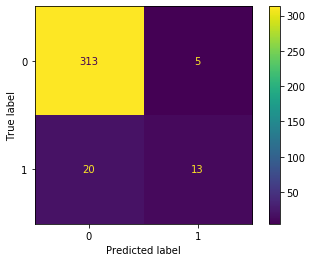

In [70]:
metrics.plot_confusion_matrix(rfc, X_test, y_test, values_format = '.0f')

Here we can see a confusion matrix to provide futher metrics used in the previous classification report.

### SVM

Testing svm to get a sense of any potential improvements with a non tree-based model.

In [71]:
svm = LinearSVC()

In [72]:
svm.fit(X_train, y_train)

LinearSVC()

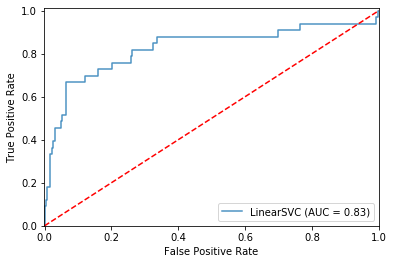

In [73]:
ax = plt.gca()
rfc_disp = metrics.plot_roc_curve(svm, X_test, y_test, ax=ax, alpha=0.8)
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.001,1])

plt.ylim([0,1.01])

# svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

SVM ROC curve looks a good bit worse thank the random forrest's.

In [74]:
svm_pred = svm.predict(X_test)
print(metrics.classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       318
           1       0.63      0.36      0.46        33

    accuracy                           0.92       351
   macro avg       0.78      0.67      0.71       351
weighted avg       0.91      0.92      0.91       351



SVM seems to be a little bit better on class 1 precision and just as bad on class 1 recall.

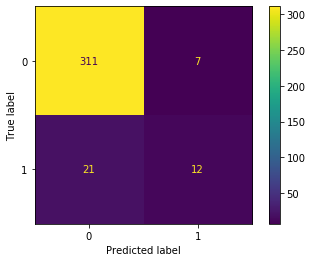

In [75]:
metrics.plot_confusion_matrix(svm, X_test, y_test, values_format = '.0f')

The confusion matrix further illustrates the challenges classifying class 1 false positives and negatives.

## Enhancing ML Models 

Given the imabalanced dataset, oversampling failures will be conducted to artificially balance the dataset during training.

### Oversample Test

A simple oversampling test using imblearn is below. The implementation randomly oversamples the minority class until it equals the number of the majority class in the training set.

In [76]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression

In [77]:
over_sampler = RandomOverSampler(random_state=99)

In [78]:
X_oversamp, y_oversamp = over_sampler.fit_sample(X_train, y_train)

In [79]:
rfc = RandomForestClassifier(n_estimators=150).fit(X_oversamp, y_oversamp)

In [80]:
rfc_pred = rfc.predict(X_test)

print(metrics.classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       318
           1       0.80      0.36      0.50        33

    accuracy                           0.93       351
   macro avg       0.87      0.68      0.73       351
weighted avg       0.92      0.93      0.92       351



The oversampling seemed to help the random forrest, but we will need more robust out of sample testing and to try other models.

### Stratified k-fold, Oversampling, and Additional Models

5 stratified kfolds will be used with oversampling to improve performance and provide a good assessment of out of sample performance. Additional classifiers will be tested as well. 

In [81]:
#Setting adaboost and gradient boosting classifers
abc = AdaBoostClassifier(n_estimators=100)
gbc = GradientBoostingClassifier(n_estimators=100)

models = [rfc, svm, abc, gbc] #List of models to be used

Stratified kfold ensures that the distribution of each class is enforced when breaking up the data into folds.

In [82]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=99) #Stratified kfold

In [83]:
out_metrics = {} #Dictionary for performance metrics
out_cm = {} #Dictionary for confusion matrix plots


#For each model in model list
for model in tqdm(models):
    
    kfold_metrics = []
    kfold_cm = []
    model_name = type(model).__name__

    # enumerate the splits and train model
    for train_ix, test_ix in kfold.split(X, y):
        # select rows
        train_X, test_X = X.iloc[train_ix], X.iloc[test_ix]
        train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
        

        #Oversample failure class
        X_oversamp, y_oversamp = over_sampler.fit_sample(train_X, train_y)

        model.fit(X_oversamp, y_oversamp)

        pred = model.predict(test_X)

        #Get classification report
        c_report = metrics.classification_report(test_y,pred, output_dict = True)
                
        #Append report to list
        kfold_metrics.append(c_report)
        
        #Append confusion matrix plot to list
        kfold_cm.append(metrics.plot_confusion_matrix(model, test_X, test_y, values_format = '.0f'))
        plt.close()
    
    #Save reports and plots using dictionaries
    out_metrics[model_name] = kfold_metrics
    out_cm[model_name] = kfold_cm



100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


Classification reports for each model are averaged over folds below.

In [84]:
metric_dfs = pd.DataFrame([])

#Loop over classification reports, and get average of all metrics
for i in out_metrics.keys():

    #Sum all metric reports and divide by the length
    m_df = sum(pd.DataFrame(report) for report in out_metrics[i])/len(out_metrics[i])
    m_df['model'] = i

    metric_dfs = metric_dfs.append(m_df, ignore_index=False)


## Model Evaluation

Below is a visualization of the average classification metrics for all models across the 5 folds.

In [85]:
#Visualizing models without support row indeces as they contain sample size and offset color map
metric_dfs[metric_dfs.index != 'support'].reset_index().style.background_gradient()

,index,0,1,accuracy,macro avg,weighted avg,model
0,precision,0.955107,0.728187,0.939269,0.841647,0.934449,RandomForestClassifier
1,recall,0.979290,0.538528,0.939269,0.758909,0.939269,RandomForestClassifier
2,f1-score,0.967017,0.615612,0.939269,0.791315,0.935090,RandomForestClassifier
3,precision,0.970562,0.415167,0.881952,0.692865,0.920161,LinearSVC
4,recall,0.897444,0.727706,0.881952,0.812575,0.881952,LinearSVC
5,f1-score,0.932516,0.527807,0.881952,0.730162,0.895758,LinearSVC
6,precision,0.982020,0.768195,0.959800,0.875108,0.962506,AdaBoostClassifier
7,recall,0.973634,0.820779,0.959800,0.897206,0.959800,AdaBoostClassifier
8,f1-score,0.977748,0.789933,0.959800,0.883841,0.960661,AdaBoostClassifier
9,precision,0.982213,0.827063,0.967499,0.904638,0.968046,GradientBoostingClassifier


We've developed some good models! Gradient Boosting looks particularly good. It does excelent with class 0, as expected, but it also has average ~0.82 scores for both class 1 precision and recall. Huge improvement from the baseline random forrest and svm. Looks like the stratified kfold and resampling methods worked well!

In [86]:
#View metrics with support row index
metric_dfs

,0,1,accuracy,macro avg,weighted avg,model
precision,0.955107,0.728187,0.939269,0.841647,0.934449,RandomForestClassifier
recall,0.979290,0.538528,0.939269,0.758909,0.939269,RandomForestClassifier
f1-score,0.967017,0.615612,0.939269,0.791315,0.935090,RandomForestClassifier
support,212.600000,21.200000,0.939269,233.800000,233.800000,RandomForestClassifier
precision,0.970562,0.415167,0.881952,0.692865,0.920161,LinearSVC
recall,0.897444,0.727706,0.881952,0.812575,0.881952,LinearSVC
f1-score,0.932516,0.527807,0.881952,0.730162,0.895758,LinearSVC
support,212.600000,21.200000,0.881952,233.800000,233.800000,LinearSVC
precision,0.982020,0.768195,0.959800,0.875108,0.962506,AdaBoostClassifier
recall,0.973634,0.820779,0.959800,0.897206,0.959800,AdaBoostClassifier


Below are the confusion matrices of the champion model, Gradient Boosting.

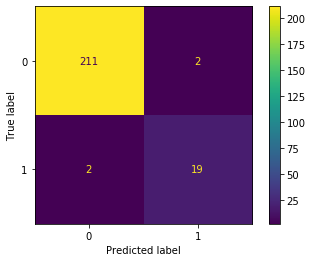

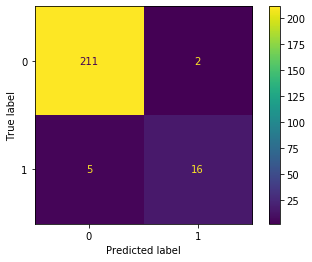

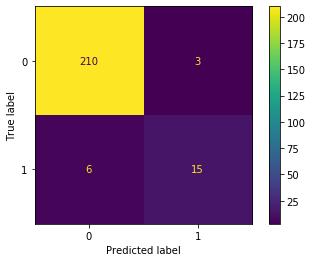

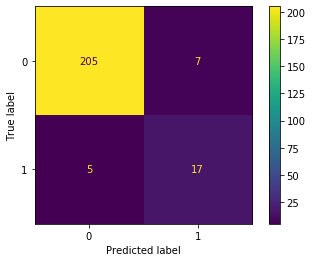

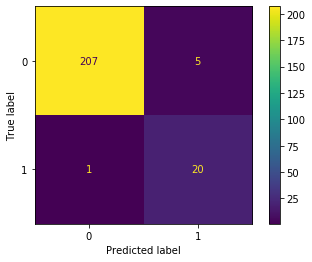

In [87]:
for i in range(len(out_cm['GradientBoostingClassifier'])):
    out_cm['GradientBoostingClassifier'][i].plot()

### Conclusions and Potential Improvements

Data Analysis, Cleaning, and Engineering:
- In this project, we were able to understand the oddities hidden in the data, clean the data, engineer features, and transform the dataset to the device level to facilitate classification of failures in a very imbalanced dataset.

ML Modeling:
 - Stratified k-fold was used to ensure a proportional number of failure entries would be present in every k fold training. 
 - Additionally, oversampling of the failure class was conducted within the training dataset of each kfold.
 - Tree based models were prioritized given their versatility and capacity to perform well with imbalanced datasets; random forrest, adaboost, and gradient boosting, and SVM were used.
 
Potential Improvements:
- In a real world setting, it would be ideal to meet with SMEs to understand the nature of the oddities discovered in the data to further refine the records included in training and could allow robust modeling of the probability of failure given a time window
- Additional failure data would only be helpful 
- Further analysis into each feature would be beneficial, especially the metrics that were flagged as categorical variables using a heuristic and modeled as binary indicators
- Further ML model experimentation would be helpful as well as in depth hyperparameter tuning.
- Deep learning models could be powerful models as a next step, perhaps LSTM to model the device sequences over time